## Data & EDA

### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score

import joblib







In [3]:
#loading the stopwords library and the nltk to be used for the text preprocessing
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eosamau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eosamau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t')

train_data = pd.concat([train_data, test_data], axis=0)
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
train_data.shape

(215063, 7)

In [6]:
train_data['condition'].value_counts()

condition
Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                           1
Sepsis                                              1
105</span> users found this comment helpful.        1
Name: count, Length: 916, dtype: int64

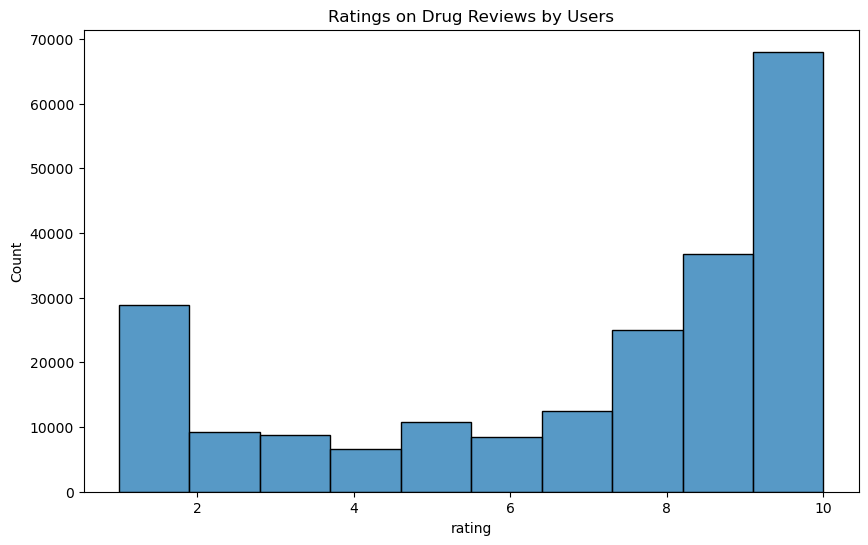

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rating'], bins=10)
plt.title('Ratings on Drug Reviews by Users')
plt.savefig('histogram_of_ratings.png')
plt.show()

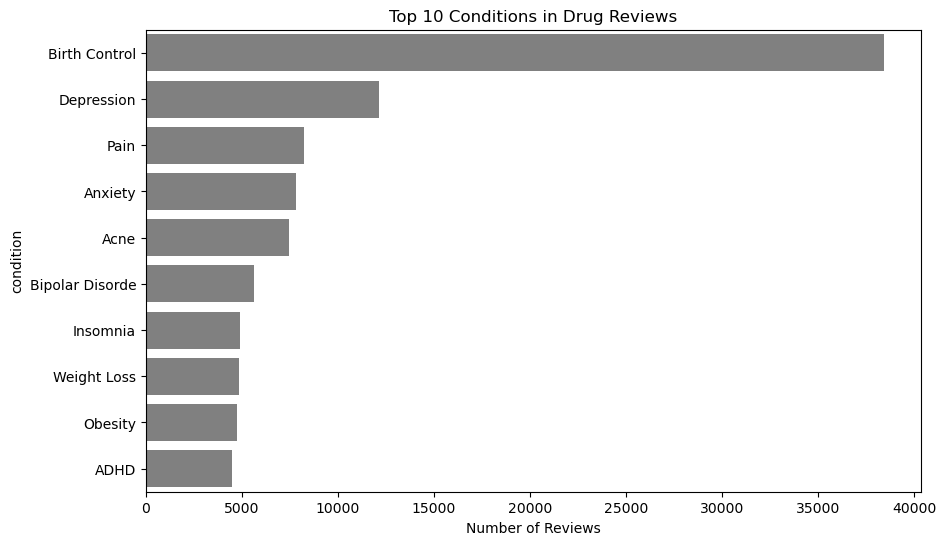

In [8]:
plt.figure(figsize=(10, 6))
top_10_conditions = train_data['condition'].value_counts().head(10)
sns.barplot(x=top_10_conditions.values, y=top_10_conditions.index, color='grey')
plt.title('Top 10 Conditions in Drug Reviews')
plt.xlabel('Number of Reviews')
plt.savefig('Top_10_conditions.png')
plt.show()


In [9]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens) #--- Joins the token into a simple word. 

train_data['processed_review'] = train_data['review'].apply(preprocess_text)
train_data['processed_review'].head()

0           side effect take combin bystol mg fish oil
1    son halfway fourth week intuniv becam concern ...
2    use take anoth oral contracept pill cycl happi...
3    first time use form birth control im glad went...
4    suboxon complet turn life around feel healthie...
Name: processed_review, dtype: object

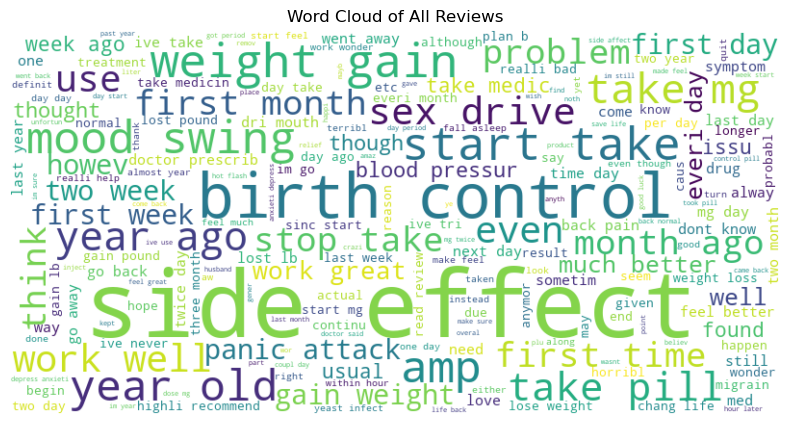

In [10]:
#creating a word cloud to visualize the most used words in 215,063 drug reviews by the users
all_words = ' '.join(train_data['processed_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.title('Word Cloud of All Reviews')

plt.savefig('wordcloud.png')
plt.show()

## Text Processing and Feature Engineering

#### TF-IDF

In [11]:
#---------TF-IDF -----------#

#Now in this stage we want to assign importance to words in the training data by using the TF IDF method which 
#can help distinguish words in accordance to how they are most used for ratings

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(train_data['processed_review'])


### Word2Vec

In [12]:

# Training a Word2Vec model tokenized reviews using the SkipGram method
word2vec_model = gensim.models.Word2Vec(sentences=train_data['processed_review'], vector_size=300, window=5, min_count=2, sg=1, workers=4)


def get_average_word2vec(tokens_list, model, vector_size):
    
    valid_words = [word for word in tokens_list if word in model.wv.key_to_index] #vocabulary from word2Vec model
    
    if not valid_words: 
        return np.zeros(vector_size) #we want to return a zero vector for the doc in case no valid words are found in the doc
    
    return np.mean(model.wv[valid_words], axis=0) # the entire review is converted into a single vector, 
                                                  #instead of different vectors for each word in the document

vector_size = word2vec_model.vector_size
train_data['word2vec_review'] = train_data['processed_review'].apply(lambda x: get_average_word2vec(x, word2vec_model, vector_size))


X_word2vec = np.vstack(train_data['word2vec_review'].values) # To convert the into a numpy array


### Encoding Ratings to Sentiments

In [62]:
def categorize_sentiment(rating):
    if rating <= 5:
        return 0  # Negative
    else:
        return 1  # Positive
    
train_data['sentiment'] = train_data['rating'].apply(categorize_sentiment)
y = train_data['sentiment']

##### Train-Test Split for TF_IDF and Word2Vec Models

In [63]:


Xtf_train, Xtf_test, ytf_train, ytf_test = train_test_split(X_tfidf, y, test_size=0.15, random_state = 1)
Xw2v_train, Xw2v_test, yw2v_train, yw2v_test = train_test_split(X_word2vec, y, test_size=0.20, stratify=y, random_state = 1)

scaler = MaxAbsScaler()
Xtf_train_scaled = scaler.fit_transform(Xtf_train)
Xtf_test_scaled = scaler.transform(Xtf_test)



In [64]:
scaler2 = StandardScaler()
Xw2v_train_scaled = scaler2.fit_transform(Xw2v_train)
Xw2v_test_scaled = scaler2.transform(Xw2v_test)

In [67]:
Xw2v_train_scaled.shape


(172050, 300)

## Model Training and Evaluation

#### TFIDF - evaluating the XGBoost, Random Forest and Logistic

In [17]:

svd = TruncatedSVD(n_components=10)
X_train_svd = svd.fit_transform(Xtf_train_scaled)
X_test_svd = svd.transform(Xtf_test_scaled)

In [18]:

xgb_classifier = XGBClassifier(n_estimators=100, subsample = 0.88,
                               learning_rate=0.1, random_state = 42, n_jobs=-1)  
xgb_classifier.fit(X_train_svd, ytf_train)
xgb_pred = xgb_classifier.predict(X_test_svd)

print("\XGBoost Classifier Results:")
print(classification_report(ytf_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=1))

\XGBoost Classifier Results:
              precision    recall  f1-score   support

    Negative       0.55      0.21      0.30      8002
     Neutral       0.64      0.01      0.02      4720
    Positive       0.64      0.96      0.77     19538

    accuracy                           0.63     32260
   macro avg       0.61      0.39      0.36     32260
weighted avg       0.62      0.63      0.54     32260



In [19]:

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5,
                                           n_jobs=-1, random_state=42)
rf_classifier.fit(X_train_svd, ytf_train)
rf_pred = rf_classifier.predict(X_test_svd)

print("\nRandom Forest Classifier Results:")
print(classification_report(ytf_test, rf_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=1))


Random Forest Classifier Results:
              precision    recall  f1-score   support

    Negative       0.55      0.02      0.04      8002
     Neutral       1.00      0.00      0.00      4720
    Positive       0.61      1.00      0.76     19538

    accuracy                           0.61     32260
   macro avg       0.72      0.34      0.27     32260
weighted avg       0.65      0.61      0.47     32260



In [20]:

logistic_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logistic_classifier.fit(X_train_svd, ytf_train)
logistic_pred = logistic_classifier.predict(X_test_svd)

print("\nLogistic Regression Results:")
print(classification_report(ytf_test, logistic_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=1))


Logistic Regression Results:
              precision    recall  f1-score   support

    Negative       0.31      0.03      0.05      8002
     Neutral       0.75      0.00      0.00      4720
    Positive       0.61      0.98      0.75     19538

    accuracy                           0.60     32260
   macro avg       0.56      0.34      0.27     32260
weighted avg       0.55      0.60      0.47     32260



Without wasting compute time with max_depth, it appears the overall accurcay is around 62% when XGBoost and RandomForest are used for the classification. We will now proceed to use the optimal number of principal components to see if the accurcay improves. After several iterations it appears the XGBoost performs better than the Random Forest Classifier. 

Also, we notice here that there are class imbalances and there we need to adjust the data to ensure there is some balance.

 ### Word2Vec - Evaluating the Logistic, Random Forest and XGBoost Model 

In [21]:
pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(Xw2v_train_scaled)
X_test_pca = pca.transform(Xw2v_test_scaled)

xgb_classifier = XGBClassifier(n_estimators=100, subsample = 0.88,
                               learning_rate=0.1, random_state = 42, n_jobs=-1)  
xgb_classifier.fit(Xw2v_train_scaled, yw2v_train)
xgb_pred = xgb_classifier.predict(Xw2v_test_scaled)

print("\XGBoost Classifier Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))



\XGBoost Classifier Results:
              precision    recall  f1-score   support

    Negative       0.59      0.12      0.20      8002
     Neutral       0.92      0.00      0.01      4720
    Positive       0.62      0.98      0.76     19538

    accuracy                           0.62     32260
   macro avg       0.71      0.37      0.32     32260
weighted avg       0.66      0.62      0.51     32260



In [22]:

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5,
                                           n_jobs=-1, random_state=42)
rf_classifier.fit(Xw2v_train_scaled, yw2v_train)
rf_pred = rf_classifier.predict(Xw2v_test_scaled)

print("\nRandom Forest Classifier Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))


Random Forest Classifier Results:
              precision    recall  f1-score   support

    Negative       0.59      0.12      0.20      8002
     Neutral       0.92      0.00      0.01      4720
    Positive       0.62      0.98      0.76     19538

    accuracy                           0.62     32260
   macro avg       0.71      0.37      0.32     32260
weighted avg       0.66      0.62      0.51     32260



In [23]:

logistic_classifier = LogisticRegression(multi_class='multinomial', solver='saga', random_state=42, max_iter=500)
logistic_classifier.fit(Xw2v_train_scaled, yw2v_train)
logistic_pred = logistic_classifier.predict(Xw2v_test_scaled)

print("\nLogistic Regression Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))


Logistic Regression Results:
              precision    recall  f1-score   support

    Negative       0.59      0.12      0.20      8002
     Neutral       0.92      0.00      0.01      4720
    Positive       0.62      0.98      0.76     19538

    accuracy                           0.62     32260
   macro avg       0.71      0.37      0.32     32260
weighted avg       0.66      0.62      0.51     32260



### Reducing Features with PCA assuming Linearity

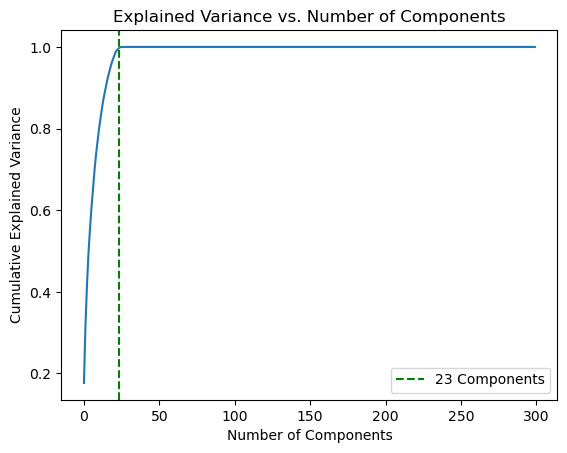

<Figure size 640x480 with 0 Axes>

In [109]:


pca = PCA().fit(Xw2v_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')

# components that explain 99% of the variance
num_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

plt.axvline(x=num_components_99, color='g', linestyle='--', label=f'{num_components_99} Components')
plt.legend()
plt.show()

plt.savefig('PCA_feature_selection.png')

# Fit PCA with the number of components that explain 99% variance, only on the training data
pca = PCA(n_components=num_components_99)
X_train_reduced = pca.fit_transform(Xw2v_train_scaled)

X_test_reduced = pca.transform(Xw2v_test_scaled)



### Reducing features with PCA Assuming Non-linearity

'''from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import numpy as np

Apply Kernel PCA with an RBF (Radial Basis Function) kernel
kpca = KernelPCA(kernel='rbf', fit_inverse_transform=True, n_components=Xw2v_train_scaled.shape[1])

Fit Kernel PCA on the scaled training data
X_kpca_train = kpca.fit_transform(Xw2v_train_scaled)

Compute explained variance using eigenvalues of the Kernel PCA
lambdas = kpca.lambdas_
explained_variance_ratio = lambdas / np.sum(lambdas)
cumulative_variance = np.cumsum(explained_variance_ratio)

Plot the cumulative explained variance
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')

Find the number of components that explain 99% of the variance
num_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

dd a vertical line at the point where 99% variance is explained
plt.axvline(x=num_components_99, color='g', linestyle='--', label=f'{num_components_99} Components')

Show the plot
plt.legend()
plt.show()

Save the plot
plt.savefig('KernelPCA_feature_selection.png')

Apply Kernel PCA with n_components that explains 99% of the variance
kpca = KernelPCA(kernel='rbf', n_components=num_components_99)

Transform both training and test data
X_train_reduced = kpca.fit_transform(Xw2v_train_scaled)
X_test_reduced = kpca.transform(Xw2v_test_scaled) '''


### Dealing with the class imbalances

In [46]:

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, yw2v_train)

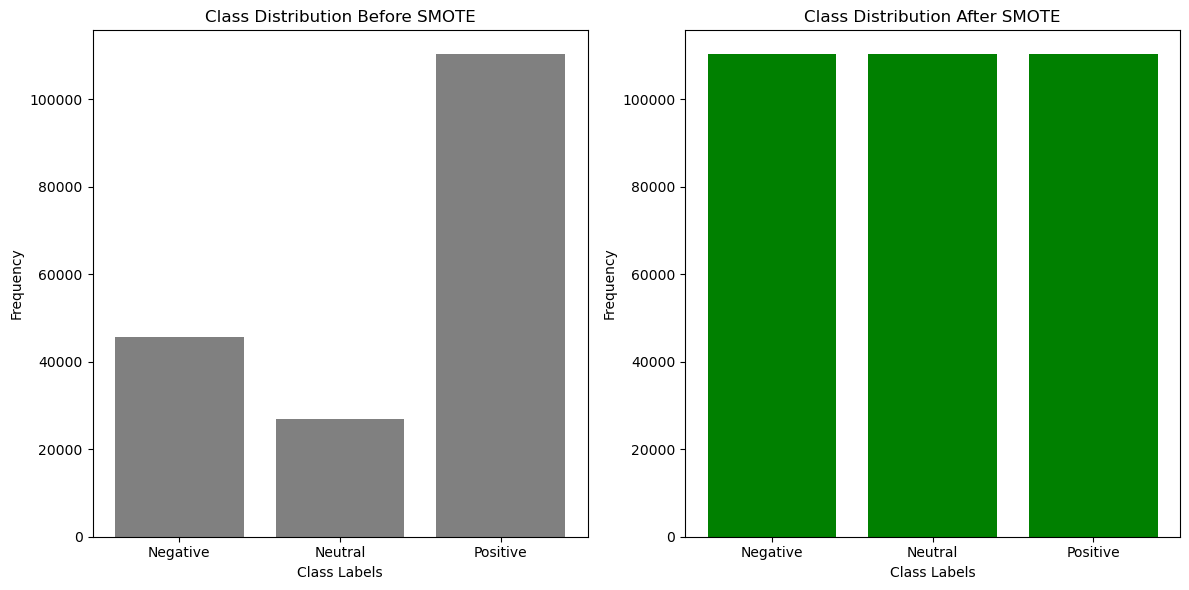

In [39]:
def plot_class_distribution(y_data, title, subplot, color, class_labels):
    unique, counts = np.unique(y_data, return_counts=True)
    plt.subplot(1, 2, subplot)
    plt.bar(unique, counts, color=color)
    plt.xlabel('Class Labels')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(unique, class_labels)  

class_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(12, 6))

plot_class_distribution(yw2v_train, 'Class Distribution Before SMOTE', 1, 'grey', class_labels)

plot_class_distribution(y_train_balanced, 'Class Distribution After SMOTE', 2, 'green', class_labels)

plt.tight_layout()
plt.savefig('Smote_Balance_Classes.png')
plt.show()



In [40]:
X_test_reduced.shape

(32260, 12)

In [78]:
yw2v_train.value_counts()

sentiment
1    120614
0     51436
Name: count, dtype: int64

In [79]:
yw2v_test.value_counts()

sentiment
1    30154
0    12859
Name: count, dtype: int64

## Tuning Parameters of the best XGB model

xgb_classifier = XGBClassifier(tree_method= 'hist', n_estimators= 100, max_depth = 25, max_delta_step = 1,
                               learning_rate=0.2, scale_pos_weight = 2.345, reg_lambda= 5, reg_alpha = 2, random_state = 42,  n_jobs= -1)  
xgb_classifier.fit(X_train_reduced, yw2v_train)
xgb_pred = xgb_classifier.predict(X_test_reduced)

In [110]:
xgb_classifier = XGBClassifier(tree_method= 'approx', n_estimators= 100, max_depth = 25, max_delta_step = 2,
                               learning_rate=0.2, scale_pos_weight = 2.345, reg_lambda= 5, reg_alpha = 2, random_state = 42,  n_jobs= -1)  
xgb_classifier.fit(X_train_reduced, yw2v_train)
xgb_pred = xgb_classifier.predict(X_test_reduced)

print("\nXGBoost Classifier Results:")
print(classification_report(yw2v_test, xgb_pred, target_names=['Negative', 'Positive']))


XGBoost Classifier Results:
              precision    recall  f1-score   support

    Negative       0.97      0.67      0.79     12859
    Positive       0.88      0.99      0.93     30154

    accuracy                           0.90     43013
   macro avg       0.92      0.83      0.86     43013
weighted avg       0.90      0.90      0.89     43013



In [71]:
repr = pd.DataFrame(yw2v_test.value_counts()).reset_index()
repr.columns = ['Class', 'Count']  
repr['Class'] = repr['Class'].map({0: 'Negative', 1: 'Positive'})  # Map numeric labels to class names

print(repr)


      Class  Count
0  Positive  30154
1  Negative  12859


## Model Evaluation

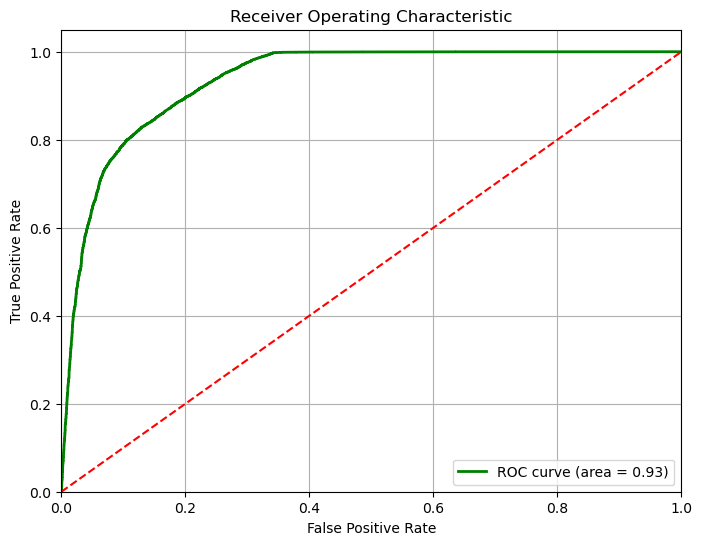

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, classification_report

# Get predicted probabilities from the trained model
xgb_prob = xgb_classifier.predict_proba(X_test_reduced)

# True labels (assumed to be 0 and 1)
true_labels = yw2v_test  # Assuming yw2v_test contains the true class labels

# Compute ROC curve and ROC AUC for the positive class
fpr, tpr, _ = roc_curve(true_labels, xgb_prob[:, 1])  # Using probabilities for the positive class
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()


These ROC curves indicate that the model has high discriminative power across all classes, with particularly strong performance in distinguishing between classes. The high AUC values (all ≥ 0.93) suggest that the model can effectively separate the classes with a low false positive rate across various classification thresholds.

## Cross Validation

In [112]:
cv_scores = cross_val_score(xgb_classifier, X_train_reduced, yw2v_train, cv=5, scoring='f1_macro')

print("Cross-Validation Scores (5-fold):", cv_scores)
print("Mean Cross-Validation F1 Score:", np.mean(cv_scores))



Cross-Validation Scores (5-fold): [0.80177927 0.79795552 0.79766656 0.80045725 0.79677134]
Mean Cross-Validation F1 Score: 0.7989259918118778


## Pipeline for Trained Models

In [115]:

# Trained Models

word2vec_model.save("word2vec_model.model")
joblib.dump(scaler2, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(xgb_classifier, "xgb_classifier.pkl")

print("Models saved successfully.")

Models saved successfully.
